In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

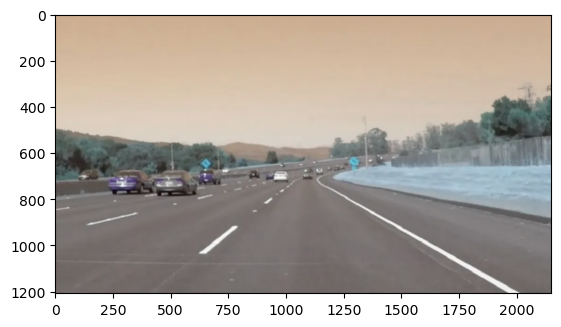

In [3]:
road = cv2.imread('images/road3.jpg')
plt.imshow(road)

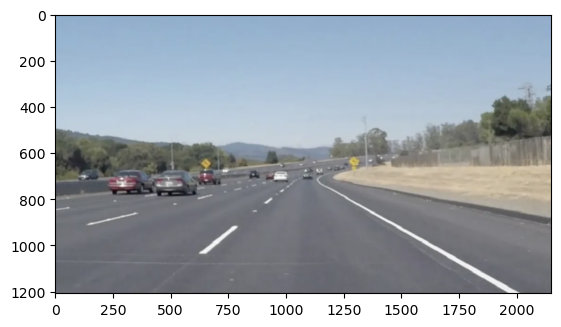

In [4]:
# original image, need to make into rgb
road_1 = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
plt.imshow(road_1)

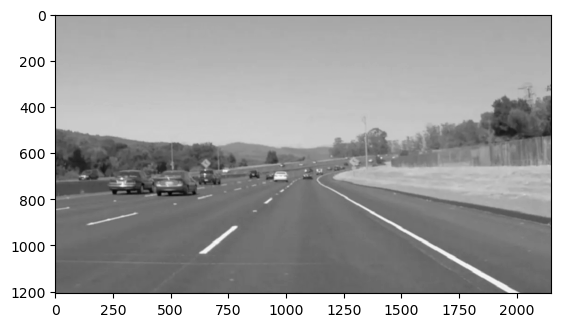

In [5]:
# only black and white
road_2 = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
plt.imshow(road_2, cmap='grey')

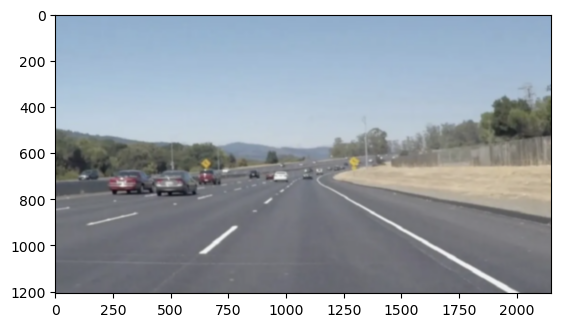

In [6]:
# apply blur
# reduces image noise and detail
road_3 = cv2.cvtColor(road, cv2.COLOR_BGR2RGB)
blur_road_3 = cv2.GaussianBlur(road_3, (15,15), 0)
plt.imshow(blur_road_3)

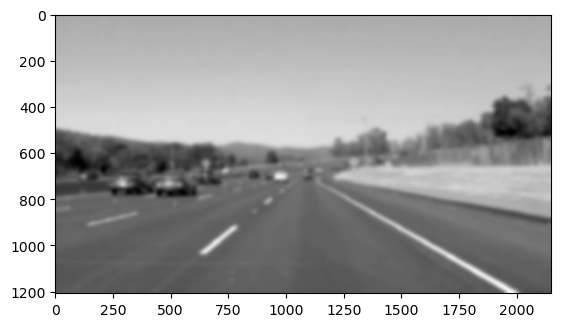

In [7]:
road_4 = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
blur_road_4 = cv2.GaussianBlur(road_4, (51,51), 0)
plt.imshow(blur_road_4, cmap='grey')

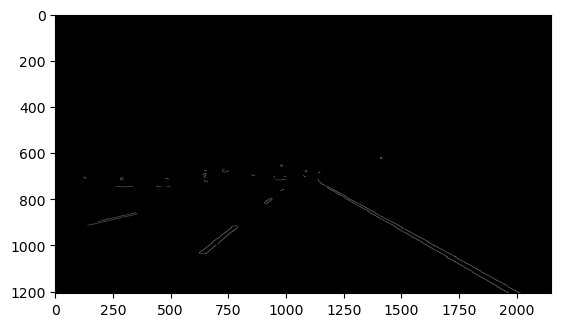

In [8]:
# apply canny edge detection
# increase threshold due to noise --> too much edges from trees
# low = lower value = more edge to be considered
# high = higher value = more strict on which pixels form as edges
# if upper too high --> edges disappear, as pixel gradient isn't high enough
road_5 = cv2.cvtColor(road, cv2.COLOR_BGR2GRAY)
lower = 150
upper = 255
road_5 = cv2.Canny(road_5, lower, upper)
plt.imshow(road_5, cmap='grey')



Text(0.5, 1.0, 'Gaussian Blur')

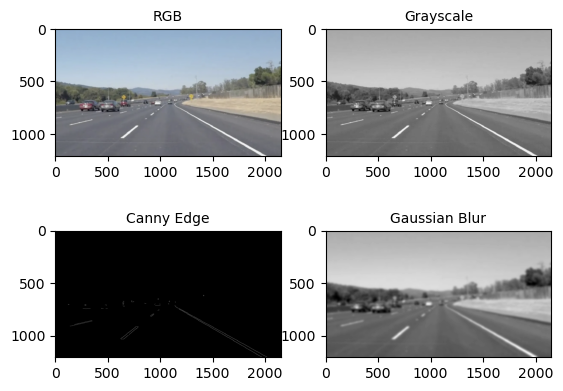

In [9]:
# display all images together

plt.subplot(2,2,1)
plt.imshow(road_1)
plt.title('RGB', fontsize=10)

plt.subplot(2,2,2)
plt.imshow(road_2, cmap='grey')
plt.title('Grayscale', fontsize=10)

plt.subplot(2,2,3)
plt.imshow(road_5, cmap='grey')
plt.title('Canny Edge', fontsize=10)

plt.subplot(2,2,4)
plt.imshow(blur_road_4, cmap='grey')
plt.title('Gaussian Blur', fontsize=10)


Text(0.5, 1.0, 'Erosion, 3x3')

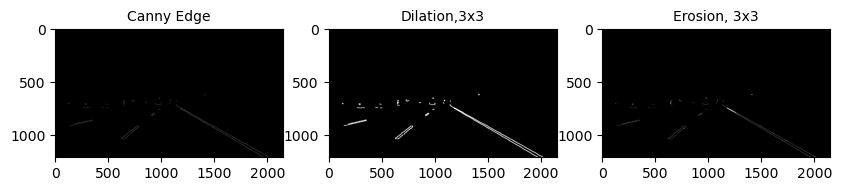

In [10]:
# erosion and dilation
# compared pixel with surrounding 24 pixels --> decides should i add or remove edge?
kernel = np.ones((5,5), np.uint8)
dilation = cv2.dilate(road_5, kernel, 1)
erosion = cv2.erode(dilation, kernel, 1)

plt.figure(figsize=(10,12))
plt.subplot(1,3,1)
plt.imshow(road_5, cmap='grey')
plt.title('Canny Edge', fontsize=10)

plt.subplot(1,3,2)
plt.imshow(dilation, cmap='grey')
plt.title('Dilation,3x3', fontsize=10)

plt.subplot(1,3,3)
plt.imshow(erosion, cmap='grey')
plt.title('Erosion, 3x3', fontsize=10)


In [11]:
# function definition that creates triangle roi of current road
def region_of_interest(road, vertices):

  # creates black screen with same shape as input road image
  # no need to specify dimensions of road image like np.zeros
  mask = np.zeros_like(road)

  # get number of color channels in image
  # (255,) * channels creates a white color matching the image format
  # ie. (255,255,255) for RGB and (255,) for grayscale 
  if len(road.shape) == 3:
    match_mask_color = (255,) * road.shape[2]

  else:
    match_mask_color = 255
    
  # fill roi with white using to defined vertices
  cv2.fillPoly(mask, vertices, match_mask_color)

  # fills in the roi with the actual image of the road
  # only pixels inside the roi will be shown, everything else is black
  masked_image = cv2.bitwise_and(road, mask)
  return masked_image

height, width, channels = road.shape

roi_vertices = [
  (0, height),
  (width / 2, height / 2),
  (width, height),
]

In [12]:
# # roi selection
# # gets top left coordinates, and width/height of roi image
# x_coor, y_coor, x_width, y_height = cv2.selectROI('ROI', road_5)
# cv2.waitKey(1)
# cv2.destroyWindow('ROI')
# cv2.waitKey(1)

# roi_road = road[y_coor : (y_coor + y_height),
#                 x_coor : (x_coor+x_width)]

# roi_road = cv2.cvtColor(roi_road, cv2.COLOR_BGR2RGB)



Text(0.5, 1.0, 'ROI')

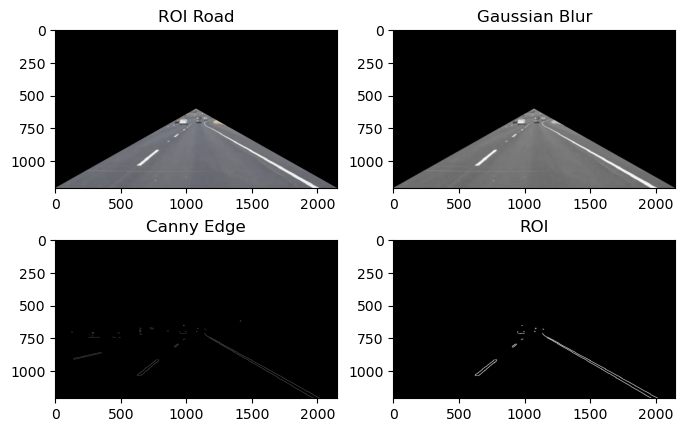

In [13]:
roi_road_image = region_of_interest(
  road,
  np.array([roi_vertices], 
  np.int32),
)

# convert to rgb colorscale
color_road = cv2.cvtColor(roi_road_image, cv2.COLOR_BGR2RGB)

# convert to grayscale
roi_road_gray = cv2.cvtColor(color_road, cv2.COLOR_BGR2GRAY)

# convert to gaussian blur, get rid of noise
roi_road_blur = cv2.GaussianBlur(roi_road_gray, (5,5), 0)

# convert to canny edge
lower = 150
upper = 250
roi_road_canny = cv2.Canny(road, lower, upper)

kernel = np.ones((3,3), np.uint8)
dilation = cv2.dilate(roi_road_canny, kernel, 1)

roi_road_image = region_of_interest(
  dilation,
  np.array([roi_vertices], np.int32),
)

plt.figure(figsize=(8,5))
plt.subplot(2,2,1)
plt.imshow(color_road)
plt.title('ROI Road')

plt.subplot(2,2,2)
plt.imshow(roi_road_blur, cmap='gray')
plt.title('Gaussian Blur')

plt.subplot(2,2,3)
plt.imshow(roi_road_canny, cmap='grey')
plt.title('Canny Edge')

plt.subplot(2,2,4)
plt.imshow(roi_road_image, cmap='grey')
plt.title('ROI')



Text(0.5, 1.0, 'Current Lane Detection Using ROI')

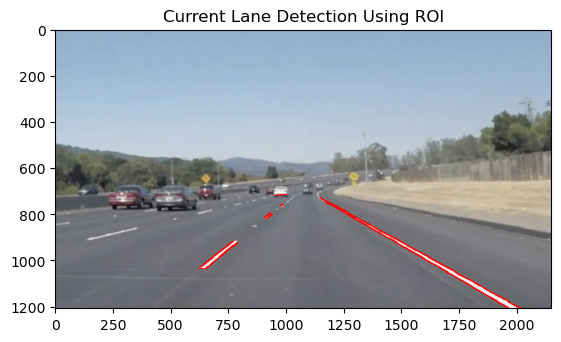

In [14]:
# parameters (image, rho, theta, threshold)
# rho = how far away from center origin
# theta = how tilted is that line
# only edges exceeding 200 threshold will be recognized as lines
# use probabilistic HT --> more efficient, only using subset of edges
# less computational
# edges too thin from canny edge --> change threshold to recognize lines easier
# minLineLength --> used to filter out smaller "noise" lines

# better to work with dilation than canny edge
# edges are easier to pick up by hough line transform --> better line detection
road_with_lines = np.copy(road_3)
lines = cv2.HoughLinesP(roi_road_image, 1, np.pi/180, 30, minLineLength=10)

# loop through each line detected by probablistic hough transform
for line in lines:
    # gives four coordinates
    x1_roi, y1_roi, x2_roi, y2_roi = line[0]

    # draws the detected lines in red onto original image
    cv2.line(road_with_lines, (x1_roi, y1_roi), (x2_roi, y2_roi), (255,0,0), 3)

plt.imshow(road_with_lines)
plt.title('Current Lane Detection Using ROI')

